In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from scipy.stats import f_oneway
import ast
from sklearn.metrics import confusion_matrix
from matplotlib_venn import venn2

# Load data

In [2]:
df_merged = pd.read_csv('../data/Merged.csv')
#remove outliers
out_inds = [3, 4, 5, 27, 28, 29]
df_merged = (df_merged.drop(out_inds)).reset_index().drop(['index'],axis=1)
X = df_merged.iloc[:,1:-1].values
X = StandardScaler().fit_transform(X)

target_labels={'Fermented':[],'Cheesy':[],'Milky':[],'Fruity':[]}
for i in range(len(df_merged.index)):
    label = list(df_merged['Label'])[i]
    for k in target_labels.keys():
        if k == label:
            target_labels[k].append(1)
        else:
            target_labels[k].append(0)          

# Model selection

In [3]:
models_to_try = {
    'LR': LogisticRegression(penalty='l1',
        solver='saga',class_weight='balanced',
        random_state=42),
    'SVC': LinearSVC(penalty='l1',class_weight='balanced',dual=False,
        random_state=42),
    'BRR':BayesianRidge(),
    'GPC':GaussianProcessClassifier(random_state=42)}

In [4]:
result_df = pd.DataFrame(
    columns=['model', 'class', 'train_auc', 'test_auc'] )
N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in target_labels.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(model, X, y= y_labels,
            cv=N_CV, scoring='roc_auc', return_train_score=True,
            verbose=1,n_jobs=4 )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'class': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )
        result_df = result_df.append(sub_result_df)

LR
LR: Fermented


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: Cheesy
LR: Milky
LR: Fruity
SVC
SVC: Fermented
SVC: Cheesy
SVC: Milky
SVC: Fruity
BRR
BRR: Fermented
BRR: Cheesy
BRR: Milky
BRR: Fruity
GPC
GPC: Fermented
GPC: Cheesy
GPC: Milky
GPC: Fruity


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concu

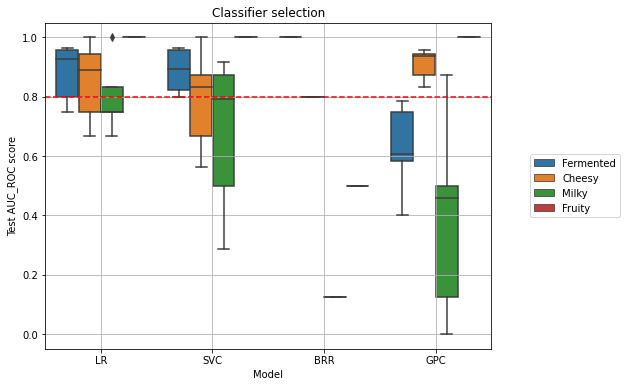

In [5]:
_, ax = plt.subplots(figsize= (8,6))
sns.boxplot(x='model', y='test_auc', data=result_df, hue='class', dodge=True, ax=ax)
ax.grid()
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.title('Classifier selection')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.xlabel('Model')
plt.ylabel('Test AUC_ROC score')
plt.savefig('../Figures/clf_select.svg',format='svg',dpi=150)

# Hyperparam optimization for Logit Regression

In [3]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver= 'saga',
            penalty = 'elasticnet',
            class_weight='balanced',
            max_iter = 500,
            verbose=1
        ),
        'param_dists': {
            'C': np.logspace(-1,2,15),
            'l1_ratio':np.linspace(0,1,num=21)
        }
    }
}

In [4]:
hyperopt_LR = {}

for y_name, y_labels in target_labels.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=50,scoring='roc_auc',n_jobs=4,
        cv=5,verbose=1,
        return_train_score=True )

    random_search_hyperopt.fit(  X ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False )
    hyperopt_LR[y_name] = hyperopt_results_df

dfs_with_class = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['class'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_class.append(hyperopt_df)
    
hyperopt_LR_df = pd.concat( dfs_with_class, axis=0, ignore_index=True)

Fermented
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Epoch 1, change: 1.00000000
Epoch 2, change: 0.23916007
Epoch 3, change: 0.19902872
Epoch 4, change: 0.05295766
Epoch 5, change: 0.05698253
Epoch 6, change: 0.04350551
Epoch 7, change: 0.03219618
Epoch 8, change: 0.02999492
Epoch 9, change: 0.03129954
Epoch 10, change: 0.02804867
Epoch 11, change: 0.02087573
Epoch 12, change: 0.01485869
Epoch 13, change: 0.01496701
Epoch 14, change: 0.01223000
Epoch 15, change: 0.00939039
Epoch 16, change: 0.00731531
Epoch 17, change: 0.00648947
Epoch 18, change: 0.00572743
Epoch 19, change: 0.00511196
Epoch 20, change: 0.00437789
Epoch 21, change: 0.00428583
Epoch 22, change: 0.00415976
Epoch 23, change: 0.00415761
Epoch 24, change: 0.00391069
Epoch 25, change: 0.00313705
Epoch 26, change: 0.00247215
Epoch 27, change: 0.00175733
Epoch 28, change: 0.00156551
Epoch 29, change: 0.00119553
Epoch 30, change: 0.00110828
Epoch 31, change: 0.00086451
Epoch 32, change: 0.00087413
Epoch 33,

Epoch 1nge: 0.00541025
Epoch 86, change: 0.00553482
Epoch 87, change: 0.00529363
Epoch 88, change: 0.00521692
Epoch 89, change: 0.00526570
Epoch 90, change: 0.00515167
Epoch 91, change: 0.00512616
Epoch 92, change: 0.00493547
Epoch 93, change: 0.00493485
Epoch 94, change: 0.00487367
Epoch 95, change: 0.00475562
Epoch 96, change: 0.00465823
Epoch 97, change: 0.00467377
Epoch 98, change: 0.00457109
Epoch 99, change: 0.00454288
Epoch 100, change: 0.00442539
Epoch 101, change: 0.00446440
Epoch 102, change: 0.00435268
Epoch 103, change: 0.00432156
Epoch 104, change: 0.00424960
Epoch 105, change: 0.00414043
Epoch 106, change: 0.00416124
Epoch 107, change: 0.00404600
Epoch 108, change: 0.00399742
Epoch 109, change: 0.00396377
Epoch 110, change: 0.00396789
Epoch 111, change: 0.00392693
Epoch 112, change: 0.00380912
Epoch 113, change: 0.00386232
Epoch 114, change: 0.00372341
Epoch 115, change: 0.00367273
Epoch 116, change: 0.00358491
Epoch 117, change: 0.00360428
Epoch 118, change: 0.00363402
E

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

3, change: 0.00093694
Epoch 274, change: 0.00093508
Epoch 275, change: 0.00092465
Epoch 276, change: 0.00091896
Epoch 277, change: 0.00091797
Epoch 278, change: 0.00091284
Epoch 279, change: 0.00090932
Epoch 280, change: 0.00090959
Epoch 281, change: 0.00090067
Epoch 282, change: 0.00089602
Epoch 283, change: 0.00088840
Epoch 284, change: 0.00088807
Epoch 285, change: 0.00088263
Epoch 286, change: 0.00087815
Epoch 287, change: 0.00086948
Epoch 288, change: 0.00087242
Epoch 289, change: 0.00086259
Epoch 290, change: 0.00086449
Epoch 291, change: 0.00085713
Epoch 292, change: 0.00085211
Epoch 293, change: 0.00085065
Epoch 294, change: 0.00084184
Epoch 295, change: 0.00084173
Epoch 296, change: 0.00083305
Epoch 297, change: 0.00083211
Epoch 298, change: 0.00083444
Epoch 299, change: 0.00081966
Epoch 300, change: 0.00081575
Epoch 301, change: 0.00081658
Epoch 302, change: 0.00081702
Epoch 303, change: 0.00080876
Epoch 304, change: 0.00080522
Epoch 305, change: 0.00080549
Epoch 306, change:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
hyperopt_LR_df.to_csv('../data/hyperopt_LR.csv')

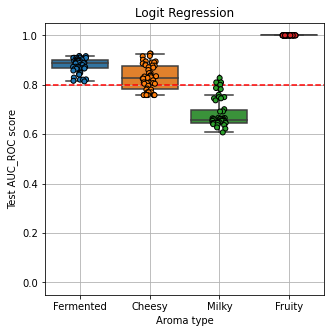

In [6]:
hyperopt_LR_df = pd.read_csv('../data/hyperopt_LR.csv')
plt.figure( figsize=(5,5))
sns.boxplot(x='class', y='mean_test_score', data=hyperopt_LR_df)
sns.stripplot(x='class', y='mean_test_score', edgecolor='black',linewidth=1, data=hyperopt_LR_df)
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('Test AUC_ROC score')
plt.xlabel('Aroma type')
plt.title('Logit Regression')
plt.ylim([-0.05,1.05])
plt.grid()
plt.savefig('../Figures/LR_aucroc.svg',format='svg',dpi=150)  

# Hyperparam optimization for Linear SVC

In [3]:
hyperopt_models = {
    'SVM': {
        'model': LinearSVC(penalty = 'l1', class_weight='balanced', max_iter = 2000, dual=False,random_state=42),
        'param_dists': {
            'C': np.logspace(-1,2,15),
            'fit_intercept':[True, False] }
    }
}

In [4]:
hyperopt_SVM = {}

for y_name, y_labels in target_labels.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['SVM']['model'],
        hyperopt_models['SVM']['param_dists'],
        n_iter=50,scoring='roc_auc',n_jobs=4,
        cv=5,verbose=1,
        return_train_score=True )

    random_search_hyperopt.fit(  X ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score', ascending=False )
    hyperopt_SVM[y_name] = hyperopt_results_df

dfs_with_class = []
for y_name, hyperopt_df in hyperopt_SVM.items():
    hyperopt_df['class'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_class.append(hyperopt_df)
    
hyperopt_SVM_df = pd.concat( dfs_with_class, axis=0, ignore_index=True)

Fermented
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Cheesy
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Milky
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fruity
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: Conv

In [5]:
hyperopt_SVM_df.to_csv('../data/hyperopt_SVM.csv')

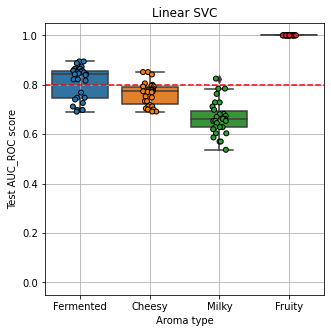

In [6]:
hyperopt_SVM_df = pd.read_csv('../data/hyperopt_SVM.csv')
plt.figure( figsize=(5,5))
sns.boxplot(x='class', y='mean_test_score', data=hyperopt_SVM_df)
sns.stripplot(x='class', y='mean_test_score', edgecolor='black',linewidth=1, data=hyperopt_SVM_df)
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('Test AUC_ROC score')
plt.xlabel('Aroma type')
plt.title('Linear SVC')
plt.ylim([-0.05,1.05])
plt.grid()
plt.savefig('../Figures/SVM_aucroc.svg',format='svg',dpi=150)  

# Confusion matrix

In [3]:
def split_data( X, y, labels, ratio=0.3):
    idx = np.arange(len(y))
    np.random.shuffle(idx)
    num_split = int(len(y) * ratio)
    idx_test, idx_train = idx[:num_split], idx[num_split:]
    X_test, X_train = np.array([ list(X[k]) for k in idx_test]), np.array( [ list(X[k]) for k in idx_train ] )
    y_test, y_train = np.array([y[k] for k in idx_test]), np.array([y[k] for k in idx_train])
    L_test, L_train = np.array([labels[k] for k in idx_test]), np.array([labels[k] for k in idx_train])
    return X_train, X_test, y_train, y_test, L_train, L_test

In [8]:
hyperopt_LR_df = pd.read_csv('../data/hyperopt_LR.csv')
sub_table = hyperopt_LR_df[ hyperopt_LR_df['class']=='Milky']
sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
params = ast.literal_eval( list(sub_table['params'])[0])
clf = LogisticRegression(solver= 'saga', penalty = 'elasticnet', class_weight='balanced',
            max_iter = 500, verbose=1)
clf.set_params( l1_ratio = params['l1_ratio'])
clf.set_params( C = params['C'])

y_true, y_pred, test_labels = [], [], []

for i in range(5):
    X_train, X_test, y_train, y_test, L_train, L_test = \
    split_data( X, target_labels['Milky'], list(df_merged['Sample']), ratio=0.3)
    y_true += list(y_test)
    test_labels += list(L_test)
    clf.fit( X_train, y_train);
    preds = clf.predict(X_test);
    y_pred += list(preds)
    
conM = confusion_matrix(y_true, y_pred);

nge: 0.00071332
Epoch 145, change: 0.00070690
Epoch 146, change: 0.00069725
Epoch 147, change: 0.00068082
Epoch 148, change: 0.00067103
Epoch 149, change: 0.00066906
Epoch 150, change: 0.00065328
Epoch 151, change: 0.00065087
Epoch 152, change: 0.00063720
Epoch 153, change: 0.00061246
Epoch 154, change: 0.00061747
Epoch 155, change: 0.00060474
Epoch 156, change: 0.00059804
Epoch 157, change: 0.00058356
Epoch 158, change: 0.00058338
Epoch 159, change: 0.00057683
Epoch 160, change: 0.00056525
Epoch 161, change: 0.00054904
Epoch 162, change: 0.00054525
Epoch 163, change: 0.00054022
Epoch 164, change: 0.00053682
Epoch 165, change: 0.00053002
Epoch 166, change: 0.00051905
Epoch 167, change: 0.00050187
Epoch 168, change: 0.00049568
Epoch 169, change: 0.00049656
Epoch 170, change: 0.00048278
Epoch 171, change: 0.00048596
Epoch 172, change: 0.00046809
Epoch 173, change: 0.00046372
Epoch 174, change: 0.00046192
Epoch 175, change: 0.00045461
Epoch 176, change: 0.00044202
Epoch 177, change: 0.000

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


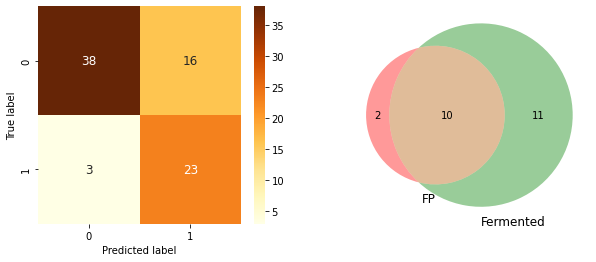

In [9]:
FP_set = []
for i in range(len(y_pred) ):
    if (y_pred[i] == True) and (y_true[i] == False):
        FP_set.append(test_labels[i])
Fermented_set = list( (df_merged[df_merged['Label']=='Fermented']['Sample']) )
        
fig, axs = plt.subplots(1,2,figsize=(10,4))
sns.heatmap(data=conM, cmap="YlOrBr", annot=True, annot_kws={"fontsize":12}, ax = axs[0] )
axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
venn2([set(FP_set), set(Fermented_set)], set_labels = ('FP','Fermented'), ax = axs[1])
plt.savefig('../Figures/conf_matrix_milky.svg',format='svg',dpi=150) 

In [14]:
hyperopt_LR_df = pd.read_csv('../data/hyperopt_LR.csv')
sub_table = hyperopt_LR_df[ hyperopt_LR_df['class']=='Fermented']
sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
params = ast.literal_eval( list(sub_table['params'])[0])
clf = LogisticRegression(solver= 'saga', penalty = 'elasticnet', class_weight='balanced',
            max_iter = 500, verbose=1)
clf.set_params( l1_ratio = params['l1_ratio'])
clf.set_params( C = params['C'])

y_true, y_pred, test_labels = [], [], []

for i in range(5):
    X_train, X_test, y_train, y_test, L_train, L_test = \
    split_data( X, target_labels['Fermented'], list(df_merged['Sample']), ratio=0.3)
    y_true += list(y_test)
    test_labels += list(L_test)
    clf.fit( X_train, y_train);
    preds = clf.predict(X_test);
    y_pred += list(preds)
    
conM = confusion_matrix(y_true, y_pred);

1
Epoch 162, change: 0.00026910
Epoch 163, change: 0.00025806
Epoch 164, change: 0.00025074
Epoch 165, change: 0.00023955
Epoch 166, change: 0.00024097
Epoch 167, change: 0.00023419
Epoch 168, change: 0.00023434
Epoch 169, change: 0.00022582
Epoch 170, change: 0.00022062
Epoch 171, change: 0.00021363
Epoch 172, change: 0.00021194
Epoch 173, change: 0.00020685
Epoch 174, change: 0.00020447
Epoch 175, change: 0.00019496
Epoch 176, change: 0.00019615
Epoch 177, change: 0.00018719
Epoch 178, change: 0.00019042
Epoch 179, change: 0.00017819
Epoch 180, change: 0.00017613
Epoch 181, change: 0.00017185
Epoch 182, change: 0.00017105
Epoch 183, change: 0.00016807
Epoch 184, change: 0.00016201
Epoch 185, change: 0.00015745
Epoch 186, change: 0.00015444
Epoch 187, change: 0.00015235
Epoch 188, change: 0.00014821
Epoch 189, change: 0.00014411
Epoch 190, change: 0.00014056
Epoch 191, change: 0.00013942
Epoch 192, change: 0.00013512
Epoch 193, change: 0.00013144
Epoch 194, change: 0.00012951
Epoch 19

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


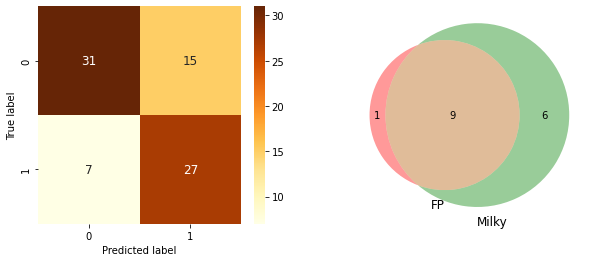

In [15]:
FP_set = []
for i in range(len(y_pred) ):
    if (y_pred[i] == True) and (y_true[i] == False):
        FP_set.append(test_labels[i])
Milky_set = list( (df_merged[df_merged['Label']=='Milky']['Sample']) )
        
fig, axs = plt.subplots(1,2,figsize=(10,4))
sns.heatmap(data=conM, cmap="YlOrBr", annot=True, annot_kws={"fontsize":12}, ax = axs[0] )
axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
venn2([set(FP_set), set(Milky_set)], set_labels = ('FP','Milky'), ax = axs[1])
plt.savefig('../Figures/conf_matrix_fermented.svg',format='svg',dpi=150) 

# Assess feature importances for LR

In [7]:
import shap
from sklearn.model_selection import train_test_split

In [8]:
hyperopt_LR_df = pd.read_csv('../data/hyperopt_LR.csv')
hyperopt_SVM_df = pd.read_csv('../data/hyperopt_SVM.csv')
cols = [ x  for x in list(df_merged.columns) if (x!= 'Label' )and( x!= 'Sample') ]
X_fi = pd.DataFrame( X, columns= cols, index=df_merged.index)

shap_vals= {}

for aroma in target_labels.keys():
    sub_table = hyperopt_LR_df[ hyperopt_LR_df['class']==aroma]
    sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
    params = ast.literal_eval( list(sub_table['params'])[0])
    clf = LogisticRegression(solver= 'saga', penalty = 'elasticnet', class_weight='balanced',
            max_iter = 500, verbose=1)
    clf.set_params( l1_ratio = params['l1_ratio'])
    clf.set_params( C = params['C'])
    y = pd.Series( target_labels[aroma] )
    X_train, X_test, y_train, y_test = train_test_split( X_fi, y, test_size=0.3, random_state=42)
    clf.fit(X_train, y_train)
    explainer = shap.Explainer(clf, X_train )
    shap_vals[aroma] = explainer(X_test)

Epoch 1, change: 1.00000000
Epoch 2, change: 0.25843633
Epoch 3, change: 0.13748216
Epoch 4, change: 0.16915648
Epoch 5, change: 0.09470108
Epoch 6, change: 0.07839887
Epoch 7, change: 0.06507973
Epoch 8, change: 0.05694361
Epoch 9, change: 0.04906322
Epoch 10, change: 0.04360874
Epoch 11, change: 0.04509409
Epoch 12, change: 0.03827202
Epoch 13, change: 0.03601121
Epoch 14, change: 0.03387402
Epoch 15, change: 0.03266668
Epoch 16, change: 0.03246728
Epoch 17, change: 0.02907617
Epoch 18, change: 0.02733970
Epoch 19, change: 0.02702307
Epoch 20, change: 0.02514635
Epoch 21, change: 0.02318409
Epoch 22, change: 0.02266776
Epoch 23, change: 0.02250427
Epoch 24, change: 0.02105055
Epoch 25, change: 0.02061930
Epoch 26, change: 0.01940193
Epoch 27, change: 0.01868538
Epoch 28, change: 0.01893405
Epoch 29, change: 0.01829934
Epoch 30, change: 0.01654793
Epoch 31, change: 0.01588378
Epoch 32, change: 0.01604745
Epoch 33, change: 0.01566160
Epoch 34, change: 0.01537460
Epoch 35, change: 0.014

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


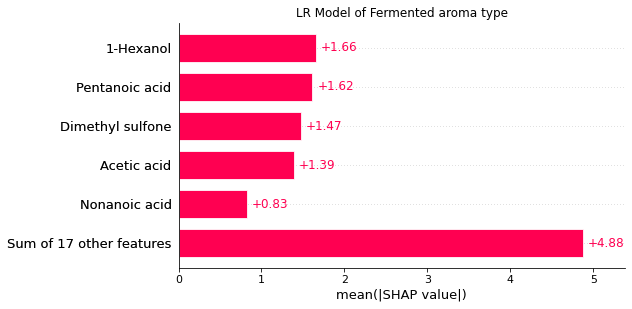

In [9]:
aroma = 'Fermented'
plt.title("LR Model of " + aroma + " aroma type")
shap.plots.bar( shap_vals[aroma],max_display=6,show = False)
plt.savefig('../Figures/LRf_'+aroma+'.svg',format='svg',dpi=150)  

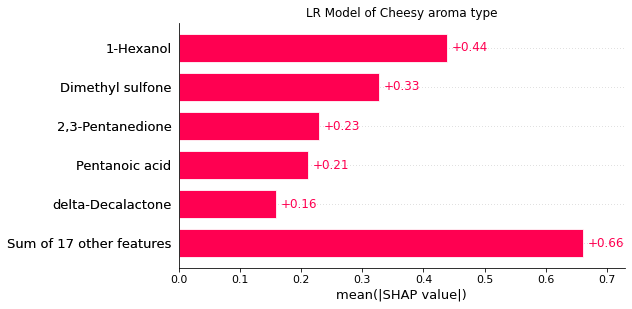

In [10]:
aroma = 'Cheesy'
plt.title("LR Model of " + aroma + " aroma type")
shap.plots.bar( shap_vals[aroma],max_display=6,show = False)
plt.savefig('../Figures/LRf_'+aroma+'.svg',format='svg',dpi=150)  

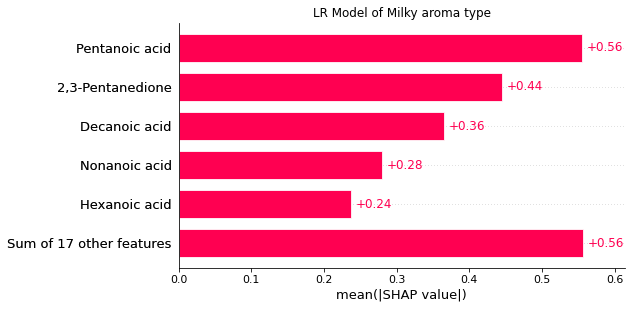

In [11]:
aroma = 'Milky'
plt.title("LR Model of " + aroma + " aroma type")
shap.plots.bar( shap_vals[aroma],max_display=6,show = False)
plt.savefig('../Figures/LRf_'+aroma+'.svg',format='svg',dpi=150)  

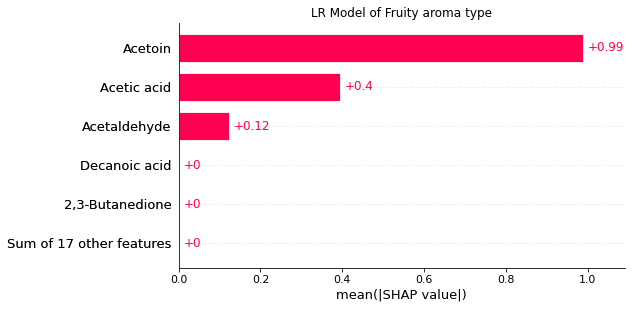

In [12]:
aroma = 'Fruity'
plt.title("LR Model of " + aroma + " aroma type")
shap.plots.bar( shap_vals[aroma],max_display=6,show = False)
plt.savefig('../Figures/LRf_'+aroma+'.svg',format='svg',dpi=150)  

# Feature distribution and ANOVA test

In [3]:
def cal_anova( data, feature ):
    temp = {x:[] for x in  np.unique( data['Label'] ) }
    for i in range(len(data.index)):
        temp[ list(data['Label'])[i] ].append( list(data[feature])[i] )
    F,p = f_oneway( *[temp[k] for k in temp.keys()] )
    return p 
    

In [4]:
features2study = ['1-Hexanol','Pentanoic acid','Dimethyl sulfone','2,3-Pentanedione', 'delta-Decalactone',
                 'Decanoic acid','Hexanoic acid','Acetoin', 'Acetic acid','Acetaldehyde']

In [5]:
for f in features2study:
    p = cal_anova( df_merged, f )
    print(f+' pval = ' + str(p))

1-Hexanol pval = 0.013525013593510911
Pentanoic acid pval = 0.0010467181655354615
Dimethyl sulfone pval = 1.1223133395272171e-05
2,3-Pentanedione pval = 0.0002540116096441974
delta-Decalactone pval = 3.899917047965083e-05
Decanoic acid pval = 0.04128122955458689
Hexanoic acid pval = 8.16337965259328e-05
Acetoin pval = 4.7654479254603733e-36
Acetic acid pval = 1.0747235743685429e-12
Acetaldehyde pval = 0.002209203895468511


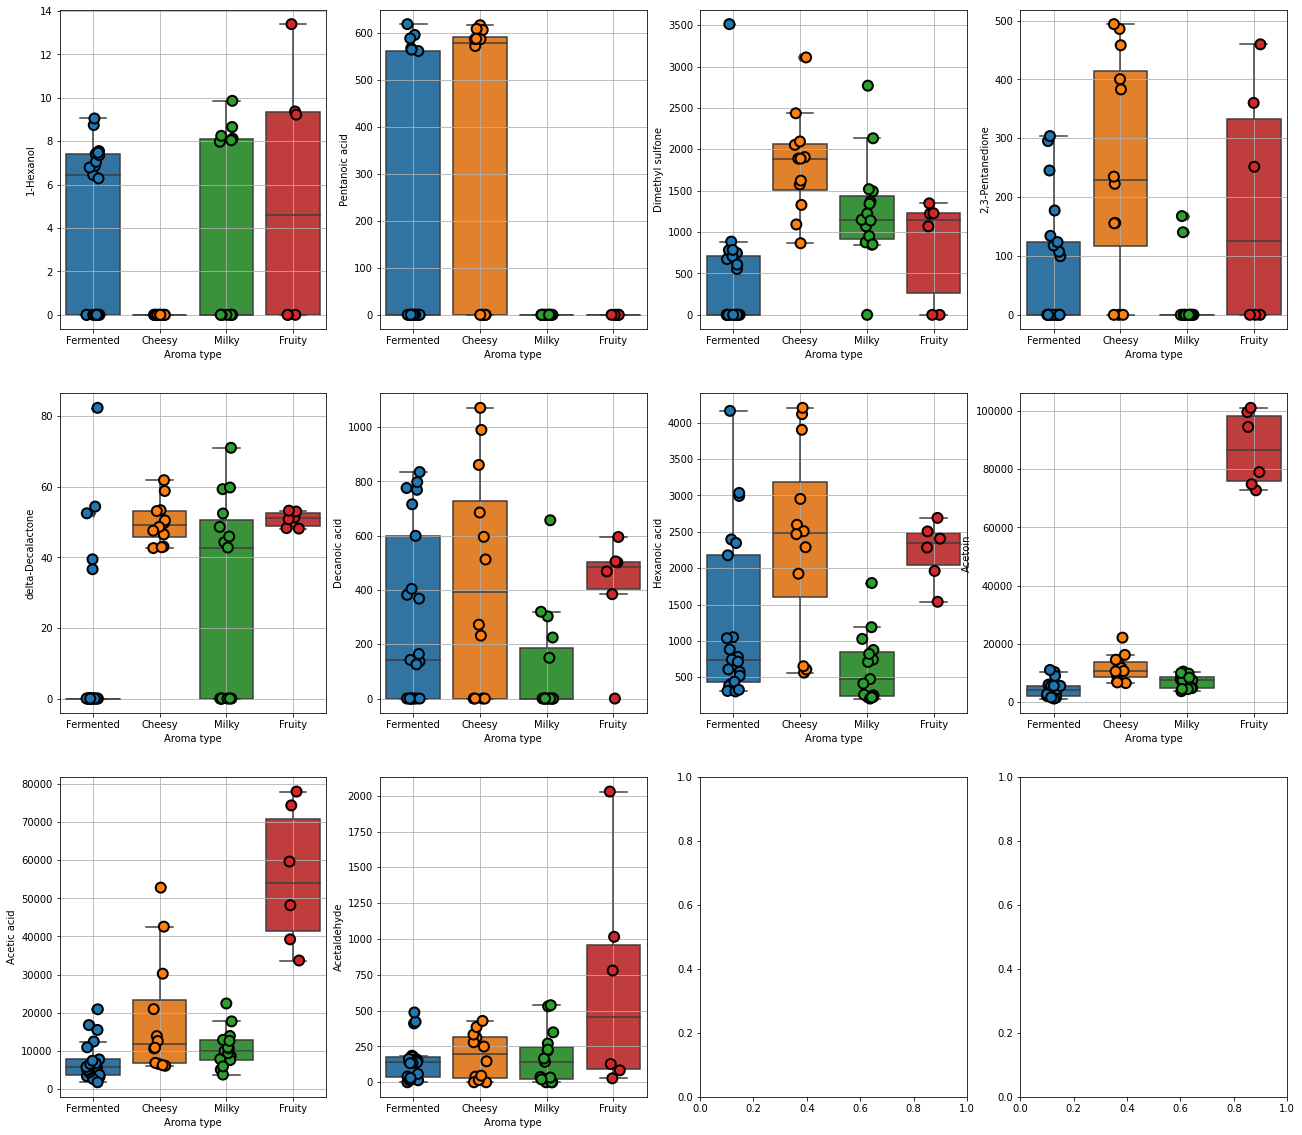

In [13]:
fig, axs = plt.subplots(3,4,figsize=(22,20))
for i in range(len(features2study)):
    x,y = int(i/4), int(i%4)
    sns.boxplot(x="Label", y=features2study[i],data=df_merged,ax = axs[x][y] ) 
    sns.stripplot(x="Label", y=features2study[i], size=10,edgecolor='black',linewidth=2,
                  data=df_merged,ax = axs[x][y] ) 
    axs[x][y].set_xlabel('Aroma type')
    axs[x][y].grid()
plt.savefig('../Figures/feature_distribution.svg',format='svg',dpi=150)

# Oneway anova test for all features

In [15]:
from matplotlib.patches import Rectangle

In [16]:
Allfeatures = list(df_merged.columns)[1:-1]
pval_list = []
for f in Allfeatures:
    pval_list.append( (f,cal_anova( df_merged, f )) )
pval_list = sorted(pval_list, key=lambda tup: tup[1])

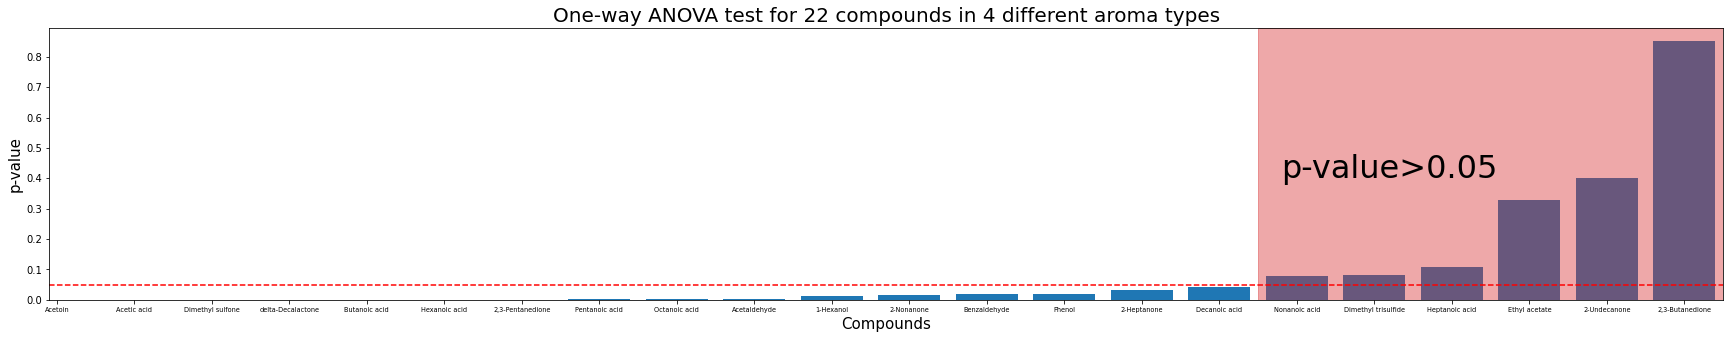

In [24]:
fig, ax = plt.subplots(1,1,figsize=(30,5))
ax.bar( [x[0] for x in pval_list], [x[1] for x in pval_list])
ax.xaxis.set_tick_params(labelsize=6.5)
ax.set_xlabel('Compounds',fontsize=15)
ax.set_ylabel('p-value',fontsize=15)
ax.axhline(y=0.05,color='r',linestyle='--')
ax.set_title('One-way ANOVA test for 22 compounds in 4 different aroma types',fontsize=20)
ax.set_xlim([-0.1,21.5])
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.text(x=15.8,y=0.4,s='p-value>0.05',fontsize=32)
ax.add_patch(Rectangle((15.5, ymin), 6.5, (ymax-ymin), color='tab:red', alpha=0.4))
plt.savefig('../Figures/anova.svg',format='svg',dpi=150) 

# Radar map 

In [26]:
import plotly.graph_objects as go
import plotly.io as pio

In [16]:
def minmax_scale( data ):
    return [ (x-min(data))/(max(data)-min(data)) for x in data] 

In [17]:
features2study = ['1-Hexanol','Pentanoic acid','Dimethyl sulfone','2,3-Pentanedione', 'delta-Decalactone',
                 'Decanoic acid','Hexanoic acid','Acetoin', 'Acetic acid','Acetaldehyde']
ind_pd = pd.DataFrame(zip(df_merged['Sample'],df_merged['Label']), columns = ['Sample','Label'])
for comp in features2study:
    ind_pd[comp] = minmax_scale( df_merged[comp] )

In [20]:
ind_pd.head()

Sample      Label  1-Hexanol  Pentanoic acid  Dimethyl sulfone  \
0  S01_1  Fermented   0.000000             0.0               0.0   
1  S01_2  Fermented   0.652883             1.0               0.0   
2  S01_3  Fermented   0.675497             0.0               1.0   
3  S14_1  Fermented   0.481257             0.0               0.0   
4  S14_2  Fermented   0.000000             0.0               0.0   

   2,3-Pentanedione  delta-Decalactone  Decanoic acid  Hexanoic acid  \
0          0.000000           0.637228       0.718105       0.492788   
1          0.496442           0.444841       0.744519       0.547445   
2          0.000000           1.000000       0.779183       0.535056   
3          0.000000           0.000000       0.000000       0.091881   
4          0.000000           0.000000       0.343740       0.143040   

    Acetoin  Acetic acid  Acetaldehyde  
0  0.091234     0.251009      0.000000  
1  0.077807     0.140229      0.086588  
2  0.098365     0.196736      0.019603  
3  0.005547     0.018663      0.091282  
4  0.008999     0.020992      0.087781

In [43]:
fig = go.Figure()
color_choices = {'Fermented':'blue','Cheesy':'orange','Milky':'green','Fruity':'red'}
for i in range(len(ind_pd.index)):
    fig.add_trace(go.Scatterpolar( r= list(ind_pd.iloc[i][2:]),
      theta=features2study,
      fill='toself',line_color=color_choices[ind_pd['Label'][i]], opacity=0.4,
      name= ind_pd['Sample'][i] ))
fig.update_layout( title_text= 'Radar chart of 10 indicator compounds for 4 aroma types',title_x = 0.5,
                  polar=dict( radialaxis=dict(visible=True,range=[0, 1.1])),showlegend=False )
pio.write_image(fig, '../Figures/indicomp_radar.svg')